# Exercise 4 - Data Augmentation
This notebook documents the effect of data augmentation on adversarial examples generated based on FGSM on a simple DNN model trained on MNIST.

The experiment comprises of the following parts:

Part 1 - Train a model on MNIST  
Part 2 - Apply FGSM to generate 5000 adversarial examples  
Part 3 - Apply data augmentation with these adversarial examples to train a new MNIST model  
Part 4 - Conclusion on the differences


## Pre-amble

### Import libraries

In [1]:
import ast
import matplotlib.pyplot as plt
import numpy as np
import os
import torch

from torch import nn
from torch.utils.data import ConcatDataset, Dataset, DataLoader, TensorDataset

from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

import torch.nn.functional as F
import torch.optim as optim

# CONSTANTS
NUM_EPOCHS = 50 # Through experiments, we saw that anything above 50 epochs was overfitting (for the simple DNN model)
FORCE_RETRAIN = False

### Class definitions
Create an MNISTNet class which is based of a neural network architecture

In [2]:
class MNISTNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 10)
        self.fc4 = nn.Linear(10, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        output = x # cross entropy in pytorch already includes softmax
        return output

### Function definitions

In [3]:
def train(model, dataloader, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    model.train()

    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        # Compute prediction error
        pred = model(x)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(x)
            print('loss: {:.4f} [{}/{}]'.format(loss, current, size))

In [4]:
def test(model, dataloader, loss_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    model.eval()
    loss, correct = 0.0, 0
    
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)

            pred = model(x)
            loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.int).sum().item()
    
    loss /= num_batches
    correct /= size
    print('Test Error: \n Accuracy: {:.2f}%, Avg loss: {:.4f}\n'.format(100 * correct, loss))
    
    return loss

In [5]:
def save_model(model, name):
    torch.save(model.state_dict(), name)
    
def load_model(model_class, name):
    model = model_class()
    model.load_state_dict(torch.load(name))

    return model

### Attack definitions
Define the attacks for FGSM and PGD

In [6]:
def denormalize(x):
    x = (x * 255).astype('uint8')
    x = x.reshape(28,28)

    return x


def display(x, y, x_adv, y_adv):
    x = denormalize(x)
    x_adv = denormalize(x_adv)

    fig, ax = plt.subplots(1, 2)

    ax[0].set(title='Original. Label is {}'.format(y))
    ax[1].set(title='Adv. sample. Label is {}'.format(y_adv))

    ax[0].imshow(x, cmap='gray')
    ax[1].imshow(x_adv, cmap='gray')
    
    plt.show()

In [7]:
def fgsm(model, x, y, eps, adv_dataset=None, target=None): # pass the target label as parameter for the targeted attack
    # x is the image sample (Tensor), y is the original label (Tensor)
    if target is not None:
        target = torch.Tensor([target]).type(torch.LongTensor)
        if y == target:
            print('\nThe sample is already classified as the target!!! Skip the sample!!!\n')
            return False

    x_adv = x.detach().clone()
    x_adv.requires_grad = True

    pred = model(x_adv)
    loss = F.cross_entropy(pred, y) # modify this line for a targeted attack

    loss.backward()

    grad_data = x_adv.grad.data
    
    # Alters the computation depending on whether this is a targeted attack
    if target is None:
        sign = +1
    else:
        sign = -1
    x_adv = torch.clamp(x_adv + (sign*eps) * grad_data.sign(), 0, 1).detach()

    pred_adv = model(x_adv)
    y_adv = pred_adv.argmax(1)

    if y_adv != y: # modify the condition to catch succesful targeted attacks
        y, y_adv = y.item(), y_adv.item()
        
        if adv_dataset is not None:
            adv_dataset.add_sample(x, y, x_adv, y_adv)
            
        return True
    else:
        return False

In [8]:
def pgd(model, x, y, eps, max_iter=10, adv_dataset=None): # pass the target label as parameter for the targeted attack
    # x is the image sample (Tensor), y is the original label (Tensor)

    x_adv = x.detach().clone()

    for _ in range(max_iter):
        x_adv.requires_grad = True

        pred = model(x_adv)
        loss = F.cross_entropy(pred, y) # modify this line for a targeted attack

        loss.backward()

        grad_data = x_adv.grad.data
        x_adv = torch.clamp(x_adv + eps * grad_data.sign(), 0, 1).detach() # modify this line for a targeted attack

        pred_adv = model(x_adv)
        y_adv = pred_adv.argmax(1)

        if y_adv != y: # modify the condition to catch succesful targeted attacks
            # x = x.detach().numpy().reshape(-1)
            y, y_adv = y.item(), y_adv.item()
            
            if adv_dataset is not None:
                adv_dataset.add_sample(x, y, x_adv, y_adv)

            print('\nFound an adversarial sample!!!\n')

            print('pred adv = {}'.format(pred_adv.detach().numpy().reshape(-1)))
            print('lbl adv = {}\n'.format(y_adv))

            display(x, y, x_adv, y_adv)
            return True

    print('\nCan\'t find adversarial samples!!!\n')
    return False

## Part 1 - Train a model on MNIST
We train the MNIST model and achieve a test accuracy of 92.55% at the end of 20 epochs

In [9]:

device = 'cpu'
train_kwargs = {'batch_size': 100}
test_kwargs = {'batch_size': 1000}
transform = transforms.ToTensor()

train_dataset = datasets.MNIST('../data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('../data', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, **train_kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, **test_kwargs)

if FORCE_RETRAIN or not os.path.exists('mnist.pt'): # Only train the model if the mnist.pt file is not there
    model = MNISTNet().to(device)

    optimizer = optim.SGD(model.parameters(), lr=0.1)
    num_of_epochs = NUM_EPOCHS

    min_loss = np.Inf
    for epoch in range(num_of_epochs):
        print('{:=^80}'.format(' Epoch ' + str(epoch) + ' '))
        #print('\n------------- Epoch {} -------------\n'.format(epoch))
        train(model, train_loader, nn.CrossEntropyLoss(), optimizer, device)
        epoch_loss = test(model, test_loader, nn.CrossEntropyLoss(), device)
        
        if epoch_loss < min_loss:
            min_loss = epoch_loss
            print('Saving model...')
            save_model(model, 'mnist.pt')
else:
    print('Model already trained - loading model from file')
    model = load_model(MNISTNet, 'mnist.pt')

Model already trained - loading model from file


#### Structure of the `train_dataset`
The train_dataset is a generator that has a total of 60,000 samples.  Each record in the generator is a tuple where the first element is a Tensor representing the image, and the second element is the label.

Here we show 9 samples as an illustration.

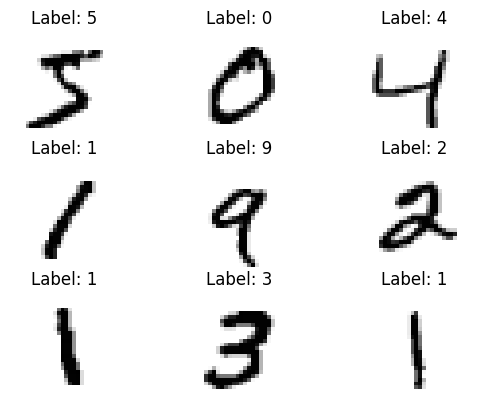

In [10]:
n_samples = 9

for i in range(n_samples):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_dataset[i][0].numpy().squeeze(), cmap='gray_r')
    plt.title('Label: {}'.format(train_dataset[i][1]))
    plt.axis('off')

### View a sample of correctly classified and misclassified images

#### Correctly classified

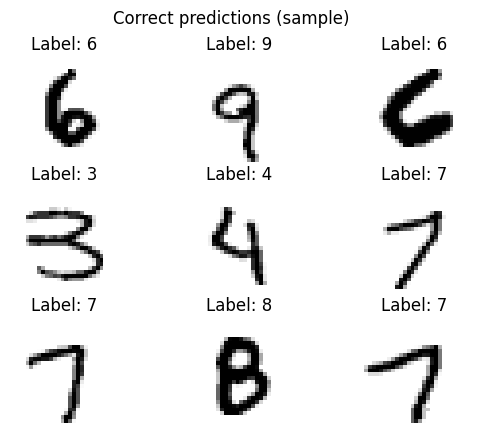

In [11]:
n_samples = 9

i = 0
for random_sample in torch.utils.data.RandomSampler(train_dataset):
    record = train_dataset[random_sample]
    img, label = record
    y_pred = np.argmax(model(img).detach().numpy())
    plt.suptitle('Correct predictions (sample)\n')
    if y_pred == label:
        plt.subplot(3, 3, i + 1)
        plt.imshow(img.numpy().squeeze(), cmap='gray_r')
        plt.title('Label: {}'.format(label))
        plt.axis('off')
        
        i += 1
        if i == n_samples:
            break

#### Incorrectly classified

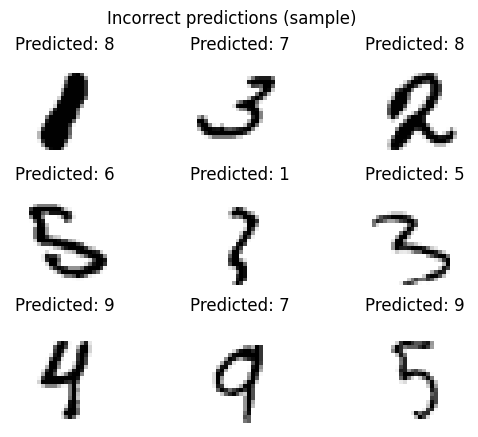

In [12]:
n_samples = 9

i = 0
for random_sample in torch.utils.data.RandomSampler(train_dataset, replacement=False):
    record = train_dataset[random_sample]
    img, label = record
    y_pred = np.argmax(model(img).detach().numpy())
    plt.suptitle('Incorrect predictions (sample)\n')
    if y_pred != label:
        plt.subplot(3, 3, i + 1)
        plt.imshow(img.numpy().squeeze(), cmap='gray_r')
        plt.title('Predicted: {}'.format(y_pred))
        plt.axis('off')
        
        i += 1
        if i == n_samples:
            break

## Part 2 - Apply FGSM to generate 5000 adversarial examples

### Create custom Dataset class to store adversarial samples
We implement the mandatory \_\_len\_\_ and \_\_getitem\_\_ methods to return a sample of the images stored as a list of tensors.
We also implement a custom add_sample() method to progressively append the new adversarial examples to the records.

In [13]:
import torch
class Adversarial_MNIST(torch.utils.data.Dataset):
    def __init__(self, transform=None, target_transform=None):
        self.x = [] # original data
        self.y = [] # original labels
        self.x_adv = [] # adversarial samples
        self.y_adv = [] # adversarial labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x_adv = self.x_adv[idx]
        y = self.y[idx]
        
        if self.transform:
            x_adv = self.transform(x_adv)
        if self.target_transform:
            y = self.target_transform(y)
            
        # we return this so that we can simply concatenate the original dataset and the adversarial dataset
        # we will retrain a new model to recognize the x_adv samples against the actual label
        return x_adv, y 
    
    def get_sample(self, idx):
        x_adv,y  = self.__getitem__(idx)
        x, y_adv = self.x[idx], self.y_adv[idx]
        
        return (x,y), (x_adv, y_adv)
            
    
    def add_sample(self, x, y, x_adv, y_adv):
        self.x.append(x)
        self.y.append(y)
        self.x_adv.append(x_adv)
        self.y_adv.append(y_adv)
        

### Analyze effect of epsilon on the adversarial samples

In [14]:
model = load_model(MNISTNet, './mnist.pt')
#for eps in [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2]:
for eps in [0.01, 0.02, 0.1, 0.2]:
    num_adv, valid_preds = 0, 0
    for train_record in train_dataset:
        x, y = train_record
        
        # Firstly, let us check if the model correctly predicts this.  If it doesn't, then it is unfair to credit it to FGSM
        y_pred = np.argmax(model(x).detach().numpy())
        if y_pred != y:
            continue
        
        valid_preds += 1
        y = torch.Tensor([y]).type(torch.LongTensor)

        if fgsm(model, x, y, eps): num_adv += 1
    print('eps: {} - Number of adversarial samples: {:,}/{:,} ({:.2f}%)'.format(eps, num_adv, valid_preds, num_adv/valid_preds*100))

eps: 0.01 - Number of adversarial samples: 3,179/56,957 (5.58%)
eps: 0.02 - Number of adversarial samples: 7,996/56,957 (14.04%)
eps: 0.03 - Number of adversarial samples: 14,038/56,957 (24.65%)
eps: 0.04 - Number of adversarial samples: 20,982/56,957 (36.84%)
eps: 0.05 - Number of adversarial samples: 27,745/56,957 (48.71%)
eps: 0.1 - Number of adversarial samples: 46,363/56,957 (81.40%)
eps: 0.2 - Number of adversarial samples: 55,444/56,957 (97.34%)


#### Generate adversarial examples to be retrained
Based on the above analysis, we need to set epislon to >= 0.02 to get the requisite number of 5000 adversarial samples

In [15]:
num_adv, eps = 0, 0.02

num_adv = 0
#num_attack = 5000
num_attack = np.Inf

adv_dataset = Adversarial_MNIST()
model = load_model(MNISTNet, './mnist.pt')

for train_record in train_dataset:
    x, y = train_record
    
    # Firstly, let us check if the model correctly predicts this.  If it doesn't, then it is unfair to credit it to FGSM
    y_pred = np.argmax(model(x).detach().numpy())
    if y_pred != y:
        continue

    y = torch.Tensor([y]).type(torch.LongTensor)
    if fgsm(model, x, y, eps, adv_dataset=adv_dataset, target=None): num_adv += 1
    
    if num_adv >= num_attack:
        break


print(f'Generated {num_adv} adversarial images')

Generated 7996 adversarial images


#### Show some random samples

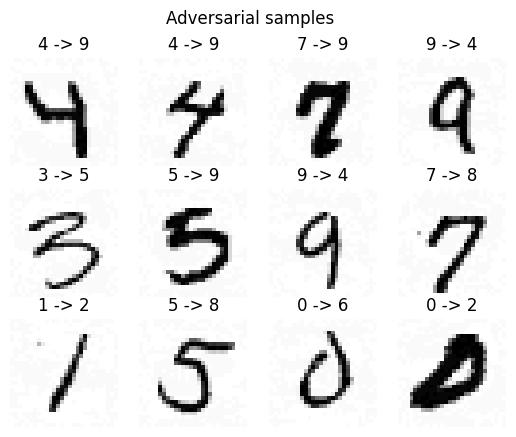

In [16]:
n_samples = 12
n_col = 4

i = 0
for random_sample in torch.utils.data.RandomSampler(adv_dataset):
    record = adv_dataset[random_sample]
    img, label = record
    y_pred = np.argmax(model(img).detach().numpy())
    plt.suptitle('Adversarial samples')
    plt.subplot(n_samples // n_col, n_col, i + 1)
    plt.imshow(img.numpy().squeeze(), cmap='gray_r')
    plt.title('{} -> {}'.format(adv_dataset.y[random_sample], adv_dataset.y_adv[random_sample]))
    plt.axis('off')
    
    i += 1
    if i == n_samples:
        break

### Concatenated Dataset
Create a concatenated Dataset object with the original training dataset, along with the new adversarial samples that have been created

In [17]:
combined_dataset_5k = ConcatDataset([train_dataset, adv_dataset])

#### Display some of the examples in the concatenated dataset
Display to be sure that the adversarial samples are correct  

Here, we should see a perturbed image with the actual training label that we want to correct it to.

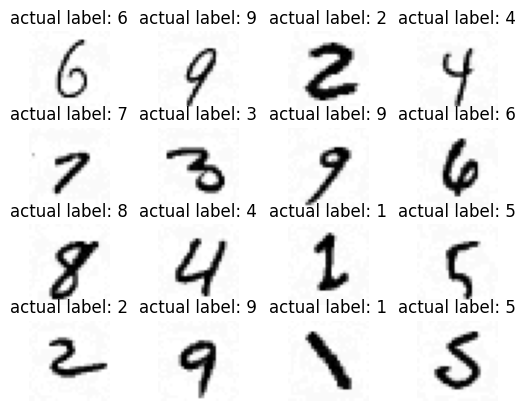

In [18]:
start_offset = 60000
n_samples = 16
n_col = 4

for i in range(start_offset, start_offset + n_samples - n_samples%n_col):
    plt.subplot(n_samples // n_col, n_col, i%start_offset + 1)
    plt.imshow(combined_dataset_5k[i][0].numpy().squeeze(), cmap='gray_r')
    plt.title('actual label: {}'.format(combined_dataset_5k[i][1]))
    plt.axis('off')

#### Assertion checks
Check that the types and shapes for the images and labels are the same as the original dataset

In [19]:
assert type(train_dataset[0]) == type(combined_dataset_5k[60000])

# Image
assert type(train_dataset[0][0]) == type(combined_dataset_5k[60000][0])
assert train_dataset[0][0].shape == combined_dataset_5k[60000][0].shape

# Label
assert type(train_dataset[0][1]) == type(combined_dataset_5k[60000][1])

In [20]:
device = 'cpu'
train_kwargs = {'batch_size': 100, 'shuffle': True}
test_kwargs = {'batch_size': 1000}
transform = transforms.ToTensor()

#train_dataset = combined_dataset
test_dataset = datasets.MNIST('../data', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(combined_dataset_5k, **train_kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, **test_kwargs)

if FORCE_RETRAIN or not os.path.exists('mnist_robust.pt'): # Only train the model if the mnist.pt file is not there
    model = MNISTNet().to(device)

    optimizer = optim.SGD(model.parameters(), lr=0.1)
    num_of_epochs = NUM_EPOCHS

    min_loss = np.Inf
    for epoch in range(num_of_epochs):
        print('{:=^80}'.format(' Epoch ' + str(epoch) + ' '))
        #print('\n------------- Epoch {} -------------\n'.format(epoch))
        train(model, train_loader, nn.CrossEntropyLoss(), optimizer, device)
        epoch_loss = test(model, test_loader, nn.CrossEntropyLoss(), device)
        
        if epoch_loss < min_loss:
            min_loss = epoch_loss
            print('Saving model...')
            save_model(model, 'mnist_robust.pt')
else:
    print('Model already trained - loading model from file')
    model_robust = load_model(MNISTNet, 'mnist_robust.pt')

Model already trained - loading model from file


## Part 4

In [21]:
model_original = load_model(MNISTNet, './mnist.pt')
model_robust = load_model(MNISTNet, './mnist_robust.pt')

In [22]:
def attack_success_rate(model, dataset, eps, attack_type='fgsm', adv_dataset=None):
    num_adv, valid_preds = 0, 0

    # Test on the entire train_dataset to see how many adversarial samples can be generated
    for sample in dataset:
        x, y = sample
        y = torch.Tensor([y]).type(torch.LongTensor)
        
        # Firstly, let us check if the model correctly predicts this.  If it doesn't, then it is unfair to credit it to FGSM
        y_pred = np.argmax(model(x).detach().numpy())
        if y_pred != y:
            continue
        
        valid_preds += 1

        # pred = model(x)
        
        if attack_type == 'fgsm':
            if fgsm(model, x, y, eps, adv_dataset, target=None): num_adv += 1

    return num_adv, valid_preds

#### Do a sanity check on the adversarial samples that were included in the training

In [23]:
len(adv_dataset)

7996

In [25]:
eps = 0.02
DISPLAY_SAMPLE = False

models_to_test = {
    'original': model_original,
    'data_augmentation': model_robust,
}

sample_size = None

#for eps in [0.005, 0.01, 0.015, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2]:
for eps in [0.02]:
    print('{:=^80}'.format(f' Epsilon = {eps} '))
    for name, model in models_to_test.items():
        if sample_size is not None and sample_size > 0 and sample_size <= len(adv_dataset):
            pass
        else:
            sample_size = len(adv_dataset) # everything
        evaluation_dataset = torch.utils.data.Subset(adv_dataset, list(range(sample_size)))
        
        adv_samples = Adversarial_MNIST()
        num_adv, valid_preds = attack_success_rate(model, evaluation_dataset, eps, attack_type='fgsm', adv_dataset=adv_samples)
        if not valid_preds:
            print(f'No valid predictions for {eps = }, {evaluation_dataset = }')
            continue
            
        success_rate = num_adv / valid_preds * 100
        print('Attack success rate with {} model = {:.2f}%'.format(name, success_rate))
        print(f'{num_adv = }, {valid_preds = }')
        
        if DISPLAY_SAMPLE:
            n_samples = 16
            n_col = 4

            for i in range(n_samples - n_samples%n_col):
                plt.subplot(n_samples // n_col, n_col, i + 1)
                plt.imshow(adv_samples[i][0].numpy().squeeze(), cmap='gray_r')
                plt.title('{} -> {}'.format(adv_samples.y[i], adv_samples.y_adv[i]))
                plt.axis('off')
            plt.show()
        else:
            print()

================================ Epsilon = 0.02 ================================
No valid predictions for eps = 0.02, evaluation_dataset = <torch.utils.data.dataset.Subset object at 0x14eb68610>
Attack success rate with data_augmentation model = 70.36%
num_adv = 5175, valid_preds = 7355



#### Analysis
From the review, we see that the samples from the FGSM samples earlier were classified correctly by the robust model.  This logically makes sense as the FGSM attack vector is a single step optimization to fool the model into misclassifying the sample.  However, if an already FGSM-perturbed image is sent to another FGSM perturbation, there is a possibility for the model to be fooled again depending on the setting of epsilon.

As such, any robust models trained using FGSM can only hope to be robust against any samples taking a single-step FGSM computation.

In [27]:
eps = 0.02
DISPLAY_SAMPLE = False

models_to_test = {
    'original': model_original,
    'data_augmentation': model_robust,
}

sample_size = None

for eps in [0.005, 0.01, 0.015, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2]:
    print('{:=^80}'.format(f' Epsilon = {eps} '))
    for name, model in models_to_test.items():
        if sample_size is not None and sample_size > 0 and sample_size <= len(train_dataset):
            pass
        else:
            sample_size = len(train_dataset) # everything
        evaluation_dataset = torch.utils.data.Subset(train_dataset, list(range(sample_size)))
        
        adv_samples = Adversarial_MNIST()
        num_adv, valid_preds = attack_success_rate(model, evaluation_dataset, eps, attack_type='fgsm', adv_dataset=adv_samples)
        success_rate = num_adv / valid_preds * 100
        print('Attack success rate with {} model = {:.2f}%'.format(name, success_rate))
        print(f'{num_adv = }, {valid_preds = }')
        
        if DISPLAY_SAMPLE:
            n_samples = 16
            n_col = 4

            for i in range(n_samples - n_samples%n_col):
                plt.subplot(n_samples // n_col, n_col, i + 1)
                plt.imshow(adv_samples[i][0].numpy().squeeze(), cmap='gray_r')
                plt.title('{} -> {}'.format(adv_samples.y[i], adv_samples.y_adv[i]))
                plt.axis('off')
            plt.show()
        else:
            print()

=============================== Epsilon = 0.005 ================================
Attack success rate with original model = 2.41%
num_adv = 1372, valid_preds = 56957

Attack success rate with data_augmentation model = 2.86%
num_adv = 1641, valid_preds = 57412

================================ Epsilon = 0.01 ================================
Attack success rate with original model = 5.58%
num_adv = 3179, valid_preds = 56957

Attack success rate with data_augmentation model = 6.81%
num_adv = 3911, valid_preds = 57412

=============================== Epsilon = 0.015 ================================
Attack success rate with original model = 9.56%
num_adv = 5447, valid_preds = 56957

Attack success rate with data_augmentation model = 12.22%
num_adv = 7017, valid_preds = 57412

================================ Epsilon = 0.02 ================================
Attack success rate with original model = 14.04%
num_adv = 7996, valid_preds = 56957

Attack success rate with data_augmentation model = 1

From what we can see, the robust model trained on FGSM is not effective against unseen adversarial samples.  This is intuitive too as the non-robust features were specific to the training samples that were seen and there needs to be more samples to have an effect.

In [28]:
len(train_dataset), len(adv_dataset)

(60000, 7996)

In [32]:
train_dataset[0][0].shape, adv_dataset[0][0].shape

(torch.Size([1, 28, 28]), torch.Size([1, 28, 28]))

In [39]:
train_dataset[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [40]:
adv_dataset[0]

(tensor([[[0.0200, 0.0000, 0.0200, 0.0200, 0.0200, 0.0000, 0.0200, 0.0000,
           0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0200, 0.0000, 0.0000, 0.0200, 0.0000,
           0.0200, 0.0000, 0.0200, 0.0200],
          [0.0000, 0.0200, 0.0200, 0.0000, 0.0000, 0.0000, 0.0200, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0200, 0.0200,
           0.0000, 0.0000, 0.0200, 0.0000, 0.0000, 0.0200, 0.0000, 0.0000,
           0.0200, 0.0200, 0.0000, 0.0200],
          [0.0000, 0.0000, 0.0200, 0.0000, 0.0000, 0.0200, 0.0200, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0200, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0200, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.1133, 0.6427, 1.0000, 0.1369, 